### **Скачиваем данные, если работете удаленно**

In [1]:
USING_COLAB = False

if USING_COLAB:
  !pip install tsfresh -q
  !gdown 10aBykx5nqKuZdn0aQhZPPB6SnQ1gp9BL
  !gdown 148cJyddPgdJu_WVaSXMjuJc4wcrt5_Lf
  !gdown 18uMWf2fqvyCh8PTF5XXZFh_oXekSdqA8
  !gdown 172usRoEzm934UdmrUDqMISwQAsGvz7Ps
  !gdown 1pZ7JRvdsSGjc-2awWcZ5EZ8CdxiUH0rb

### **Импорты**

In [2]:
# Other tools
import random
import os
from tqdm import tqdm
from copy import deepcopy

# Visual
import matplotlib.pyplot as plt
import seaborn as sns

# Data Working
import pandas as pd
import numpy as np

#graph
import networkx as nx

In [ ]:
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=700, font_size=16)
# plt.show()

### **Настройка визуализаций**

In [2]:
# Session settings
pd.set_option('display.max_rows', 15)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(context='talk', style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams["font.weight"] = "bold"

# make results reproducable
def set_seed(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(SEED)

SEED = 69
set_seed(SEED)

### **Подгружаем данные**

In [3]:
if not USING_COLAB:
  root_data_path = "data"
else:
  root_data_path = "/content"

X_train = pd.read_csv(f"{root_data_path}/train_X.csv")
y_train_all = pd.read_csv(f"{root_data_path}/train_y.csv")

train = X_train.merge(y_train_all, on=["contract_id", "report_date"], how="left")
test = pd.read_csv(f"{root_data_path}/test_X.csv")

y_train_all = train["default6"]
train_orig = deepcopy(train)

### **Распределение nan`ов**

Есть колонки с большим кол-вом нанов, будем удалять такие, остальные заполнять медианным значением

In [ ]:
sns.histplot(
    train.isna().sum().values,
    bins=30,
    label='train'
)
sns.histplot(
    test.isna().sum().values,
    bins=30,
    label='test'
)
plt.legend()
plt.show()

### **Посмотрим на данные в динамике по времени**

##### *Для начало выделим временные признаки*

In [4]:
def gen_date_features(train, test, date_cols):

    new_dates_cols = []

    for date_col in date_cols:
        train[date_col] = pd.to_datetime(train[date_col])
        test[date_col] = pd.to_datetime(test[date_col])

        train[f"{date_col}_day"] = train[date_col].apply(lambda x: x.day)
        train[f"{date_col}_month"] = train[date_col].apply(lambda x: x.month)
        train[f"{date_col}_day_of_week"] = train[date_col].apply(lambda x: x.day_name())
        train[f"{date_col}_is_weekend"] = train[f"{date_col}_day_of_week"].isin(['Saturday', 'Sunday']).astype(int)


        test[f"{date_col}_day"] = test[date_col].apply(lambda x: x.day)
        test[f"{date_col}_month"] = test[date_col].apply(lambda x: x.month)
        test[f"{date_col}_day_of_week"] = test[date_col].apply(lambda x: x.day_name())
        test[f"{date_col}_is_weekend"] = test[f"{date_col}_day_of_week"].isin(['Saturday', 'Sunday']).astype(int)

        new_dates_cols.extend([f"{date_col}_day", f"{date_col}_month", f"{date_col}_day_of_week", f"{date_col}_is_weekend"])

    return train, test, new_dates_cols

In [6]:
train, test, new_date_features = gen_date_features(train, test, date_cols=["report_date", "contract_date"])

##### *Теперь посмотрим на даты в трейне/тесте*

In [7]:
print(f"Самое ранняя дата начала контракта в трейне: {train['contract_date'].min()}")
print(f"Самое поздняя дата начала контракта в трейне: {train['contract_date'].max()}")
print(f"Дата последнего отчёта в трейне: {train['report_date'].max()}")

print(f"Самое ранняя дата начала контракта в тесте: {test['contract_date'].min()}")
print(f"Самое поздняя дата начала контракта в тесте: {test['contract_date'].max()}")
print(f"Дата последнего отчёта в тесте: {test['report_date'].max()}") 

Самое ранняя дата начала контракта в трейне: 2022-01-09 21:00:00
Самое поздняя дата начала контракта в трейне: 2023-07-22 21:00:00
Дата последнего отчёта в трейне: 2023-07-23 00:00:00
Самое ранняя дата начала контракта в тесте: 2022-01-16 21:00:00
Самое поздняя дата начала контракта в тесте: 2023-09-21 21:00:00
Дата последнего отчёта в тесте: 2023-09-24 00:00:00


##### *Теперь посмотрим на распределение отчётов по месяцам*

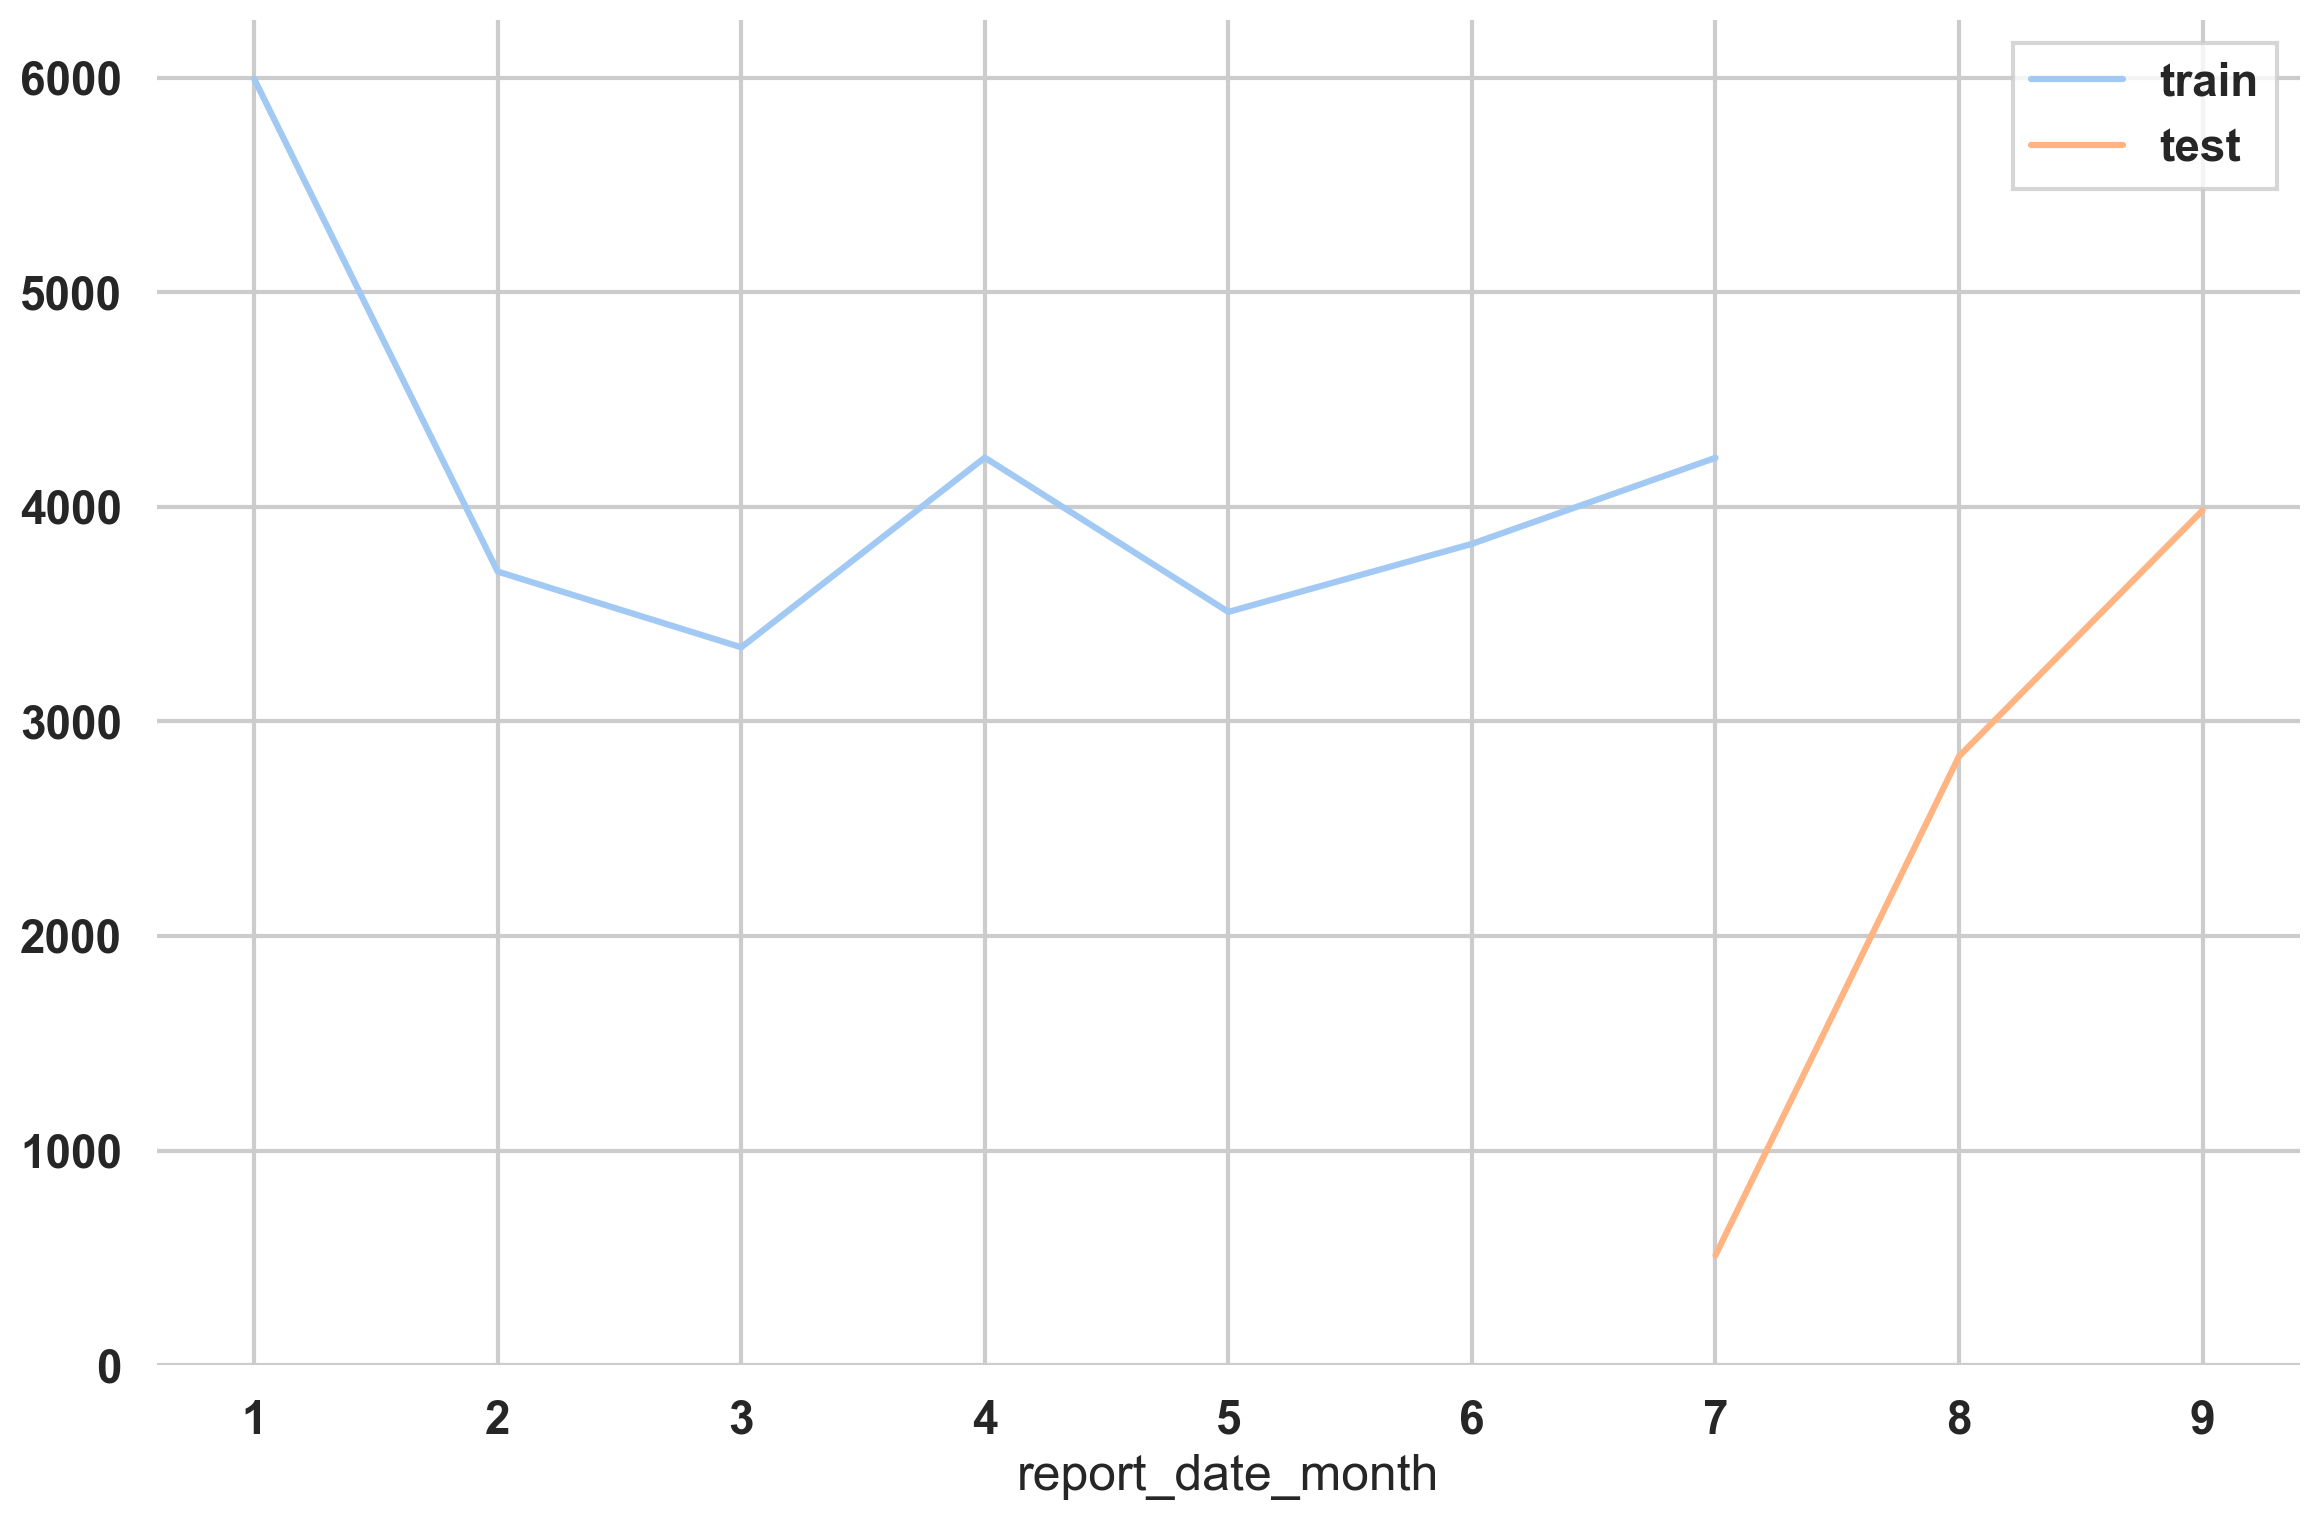

In [10]:
train['report_date'] = pd.to_datetime(train['report_date'] )
test['report_date'] = pd.to_datetime(test['report_date'] )

train['report_date_month'] = train['report_date'].apply(lambda x: x.month)
test['report_date_month'] = test['report_date'].apply(lambda x: x.month)

sns.lineplot(
    train.groupby('report_date_month').size(),
    label='train'
)
sns.lineplot(
    test.groupby('report_date_month').size(),
    label='test'
)
plt.legend()
plt.ylim(0)
plt.show()

Все наблюдения представлены за 2023 год. Видно, что контракты в трейне заканчиваются в Июле*, а в тесте наоборот - начинаются в Июле и заканчиваются в декабре. Отсюда следует, что в данных в некоторых фичах может быть timeshift в тесте, относительно трейна

'*' данные выводы основаны на предоставленном датасете, на самом деле контракты могут быть обрезаны как слева, так и справа

### **Смотрим на распределение контрактов по месяцам в которых они начались, проверка на сезонность**

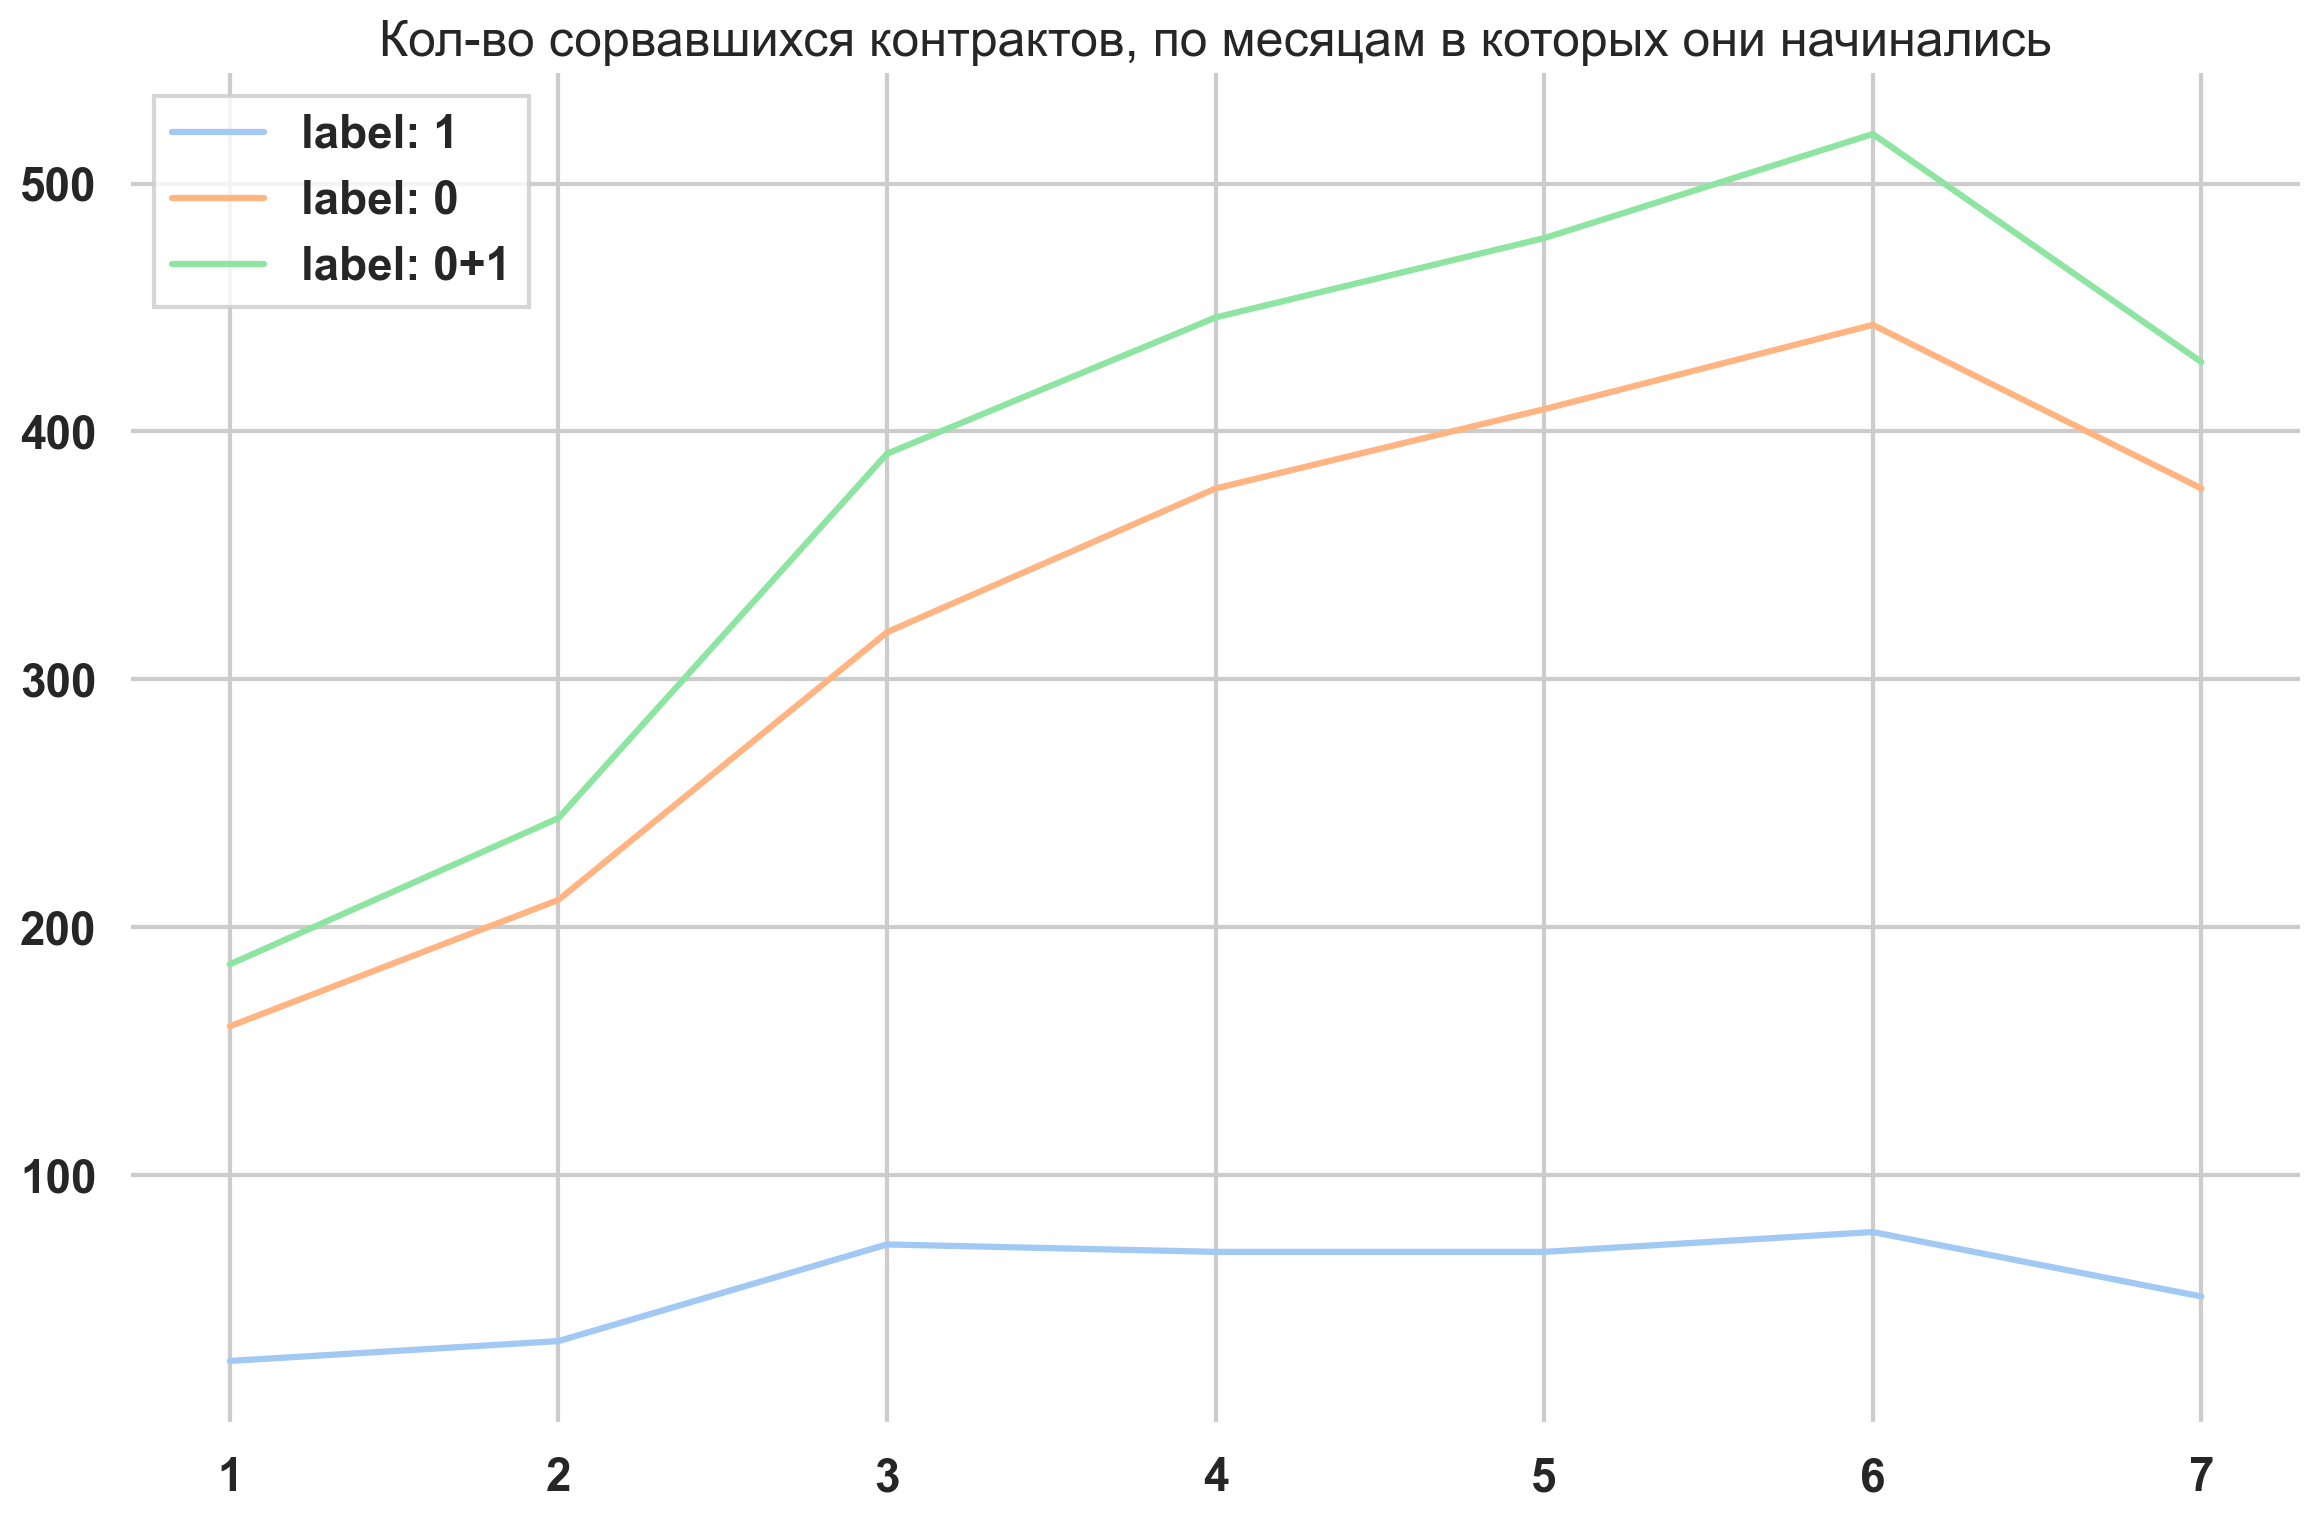

In [15]:
values_1 = []
values_0 = []
months = []

for i in range(1, 8):
  new_target = train.sort_values(["contract_date"]).groupby("contract_id", as_index=False)["default6"].agg(lambda x: (1 if 1 in list(x) else 0))
  report_date_month = train.sort_values(["contract_date"]).groupby("contract_id", as_index=False)["contract_date_month"].agg(lambda x: x.iloc[0])
  tmp_train = pd.DataFrame.from_dict({"contract_date_month" : report_date_month["contract_date_month"], "contract_id" : report_date_month["contract_id"]})
  tmp_train = tmp_train.merge(new_target, on="contract_id", how="left")
  value_0 = tmp_train.groupby("contract_date_month").get_group(i)["default6"].value_counts().loc[0]
  value_1 = tmp_train.groupby("contract_date_month").get_group(i)["default6"].value_counts().loc[1]
  values_1.append(value_1)
  values_0.append(value_0)
  months.append(i)

sns.lineplot(x=months, y=values_1, label="label: 1")
sns.lineplot(x=months, y=values_0, label="label: 0")
sns.lineplot(x=months, y=[v1+v0 for v1, v0 in zip(values_1, values_0)], label='label: 0+1')
plt.legend()
plt.title(label="Кол-во сорвавшихся контрактов, по месяцам в которых они начинались")
plt.show()

Чёткой сезонности выявить нельзя

### **Посмотрим на распределение непрерывных фичей на трейне/тесте**

In [ ]:
for column in train.columns:
  if column not in ["contract_id", "project_id", "contractor_id", "report_date", "specialization_id", "contract_date", "building_id", "default6"]:
    sns.kdeplot(train[column],label="train")
    sns.kdeplot(test[column],label="test")
    plt.title(column)
    plt.legend()
    plt.show()

## **Feature generation**

### Добавление признаков с shift`ом

In [ ]:
# Sort the data
def add_shifted_features(train, test, target_columns, lags=[1]):

  train = train.sort_values(by=['contract_id', 'report_date']).reset_index(drop=True)
  test = test.sort_values(by=['contract_id', 'report_date']).reset_index(drop=True)

  def add_lagged_features(group, lags, target_column):
      for lag in lags:
          group[f'{target_column}_lag_{lag}'] = group[target_column].shift(lag)
      return group

  new_features = []

  for target_column in tqdm(target_columns):

    grouped_data_train = train.groupby('contract_id')[target_columns].apply(
        add_lagged_features,
        lags=lags,
        target_column=target_column
      )

    grouped_data_test = test.groupby('contract_id')[target_columns].apply(
      add_lagged_features,
      lags=lags,
      target_column=target_column
    )

    new_features_target_col = [f'{target_column}_lag_{lag}' for lag in lags]

    train = pd.concat([train, grouped_data_train[new_features_target_col].reset_index(drop=True)], axis=1)
    test = pd.concat([test, grouped_data_test[new_features_target_col].reset_index(drop=True)], axis=1)

    new_features.extend(new_features_target_col)

  return train, test, new_features

In [ ]:
add_shifted_features(
    train,
    test,
    target_columns=[
        "agg_spass_applications__g_contract__appl_count_week__mean__1W",
        "agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_24M"
    ],
    lags=[1, 2]
)[0]

### Добавление признаков с rolling

In [ ]:
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tsfresh import extract_features

def extract_ts_features(train, test, target_columns, window_size=None, param_type="min"):
  # params EfficientFCParameters works for feature count <= 5
  # params MinimalFCParameters works for every feature count

  target_df_train = train.loc[:, target_columns + ["contract_id", "report_date"]]
  target_df_test = test.loc[:, target_columns + ["contract_id", "report_date"]]
  target_column_id = "contract_id"

  if window_size != None:

    train_rolled = roll_time_series(
        target_df_train,
        column_id="contract_id",
        max_timeshift=window_size,
        column_sort="report_date",
        n_jobs=4
    ).drop(columns=["contract_id"])

    target_column_id = "id"
    target_df_train = train_rolled.copy()


    test_rolled = roll_time_series(
        target_df_test,
        column_id="contract_id",
        max_timeshift=window_size,
        column_sort="report_date",
        n_jobs=4
    ).drop(columns=["contract_id"])

    target_df_test = test_rolled.copy()

  extracted_train_features = extract_features(
    target_df_train,
    column_id=target_column_id,
    column_sort="report_date",
    n_jobs=4,
    default_fc_parameters=(MinimalFCParameters() if param_type=="min" else EfficientFCParameters())
  )

  extracted_test_features = extract_features(
    target_df_test,
    column_id=target_column_id,
    column_sort="report_date",
    n_jobs=4,
    default_fc_parameters=(MinimalFCParameters() if param_type=="min" else EfficientFCParameters())
  )

  return extracted_train_features, extracted_test_features

In [ ]:
train_columns_to_map = {}
for column in train.columns:
  if "__" in column:
     train_columns_to_map[column] = column.replace('__', '_')

train = train.rename(train_columns_to_map, axis=1)
test = test.rename(train_columns_to_map, axis=1)

train_features, test_features = extract_ts_features(
    train,
    test,
    window_size=None,
    target_columns=["agg_spass_applications_g_contract_appl_count_week_mean_1W"],
    param_type="eff"
)

# train = train.rename({v:k for k, v in train_columns_to_map.items()}, axis=1)
# test = test.rename({v:k for k, v in train_columns_to_map.items()}, axis=1)

# train_features = train_features.reset_index()
# test_features = test_features.reset_index()

# train = train.merge(train_features.drop(columns=["index"]), right_on=["level_0", "level_1"], left_on=["contract_id", "report_date"])
# test = train.merge(test_features.drop(columns=["index"]), right_on=["level_0", "level_1"], left_on=["contract_id", "report_date"])

### Добавление кастомных фичей

In [ ]:
def gen_feature_by_id(train, test, id):

  train_no_dublicates = train.drop_duplicates(subset=["contract_id"])
  test_no_dublicates = test.drop_duplicates(subset=["contract_id"])

  train[f"count_{id}_contracts_started_before"] = 0
  train[f"count_{id}_contracts_started_after"] = 0
  train[f"mean_contract_init_sum_{id}_contracts_started_before"] = 0
  train[f"mean_contract_init_sum_{id}_contracts_started_after"] = 0
  train[f"diff_mean_contract_init_sum_{id}_contracts_started_before"] = 0
  train[f"diff_mean_contract_init_sum_{id}_contracts_started_after"] = 0


  test[f"count_{id}_contracts_started_before"] = 0
  test[f"count_{id}_contracts_started_after"] = 0
  test[f"mean_contract_init_sum_{id}_contracts_started_before"] = 0
  test[f"mean_contract_init_sum_{id}_contracts_started_after"] = 0
  test[f"diff_mean_contract_init_sum_{id}_contracts_started_before"] = 0
  test[f"diff_mean_contract_init_sum_{id}_contracts_started_after"] = 0

  train_unique_contract_ids = list(train["contract_id"].unique())
  test_unique_contract_ids = list(test["contract_id"].unique())

  def f_(df_, df_contract_ids):

    print("count feature in df")
    for contract_id in tqdm(df_contract_ids):

      cur_contract = df_[df_.contract_id == contract_id]
      cur_contract_contractor = cur_contract[f"{id}_id"].unique()[0]
      cur_contract_date = cur_contract["contract_date"].unique()[0]
      cur_contract_init_sum = cur_contract["contract_init_sum"].unique()[0]

      started_before_in_train = train_no_dublicates.query(f"{id}_id == @cur_contract_contractor and contract_date < @cur_contract_date")
      started_after_in_train = train_no_dublicates.query(f"{id}_id == @cur_contract_contractor and contract_date >= @cur_contract_date")

      started_before_in_test = test_no_dublicates.query(f"{id}_id == @cur_contract_contractor and contract_date < @cur_contract_date")
      started_after_in_test = test_no_dublicates.query(f"{id}_id == @cur_contract_contractor and contract_date >= @cur_contract_date")

      contract_init_sum_mean_started_before_in_train = started_before_in_train["contract_init_sum"].tolist()
      contract_init_sum_mean_started_after_in_train = started_after_in_train["contract_init_sum"].tolist()
      contract_init_sum_mean_started_before_in_test = started_before_in_test["contract_init_sum"].tolist()
      contract_init_sum_mean_started_after_in_test = started_after_in_test["contract_init_sum"].tolist()

      contract_init_sum_mean_started_before = contract_init_sum_mean_started_before_in_train + contract_init_sum_mean_started_before_in_test
      contract_init_sum_mean_started_before =  (
          sum(contract_init_sum_mean_started_before) / len(contract_init_sum_mean_started_before)
          if len(contract_init_sum_mean_started_before) != 0 else 0
      )

      contract_init_sum_mean_started_after= contract_init_sum_mean_started_after_in_train + contract_init_sum_mean_started_after_in_test
      contract_init_sum_mean_started_after = (
          sum(contract_init_sum_mean_started_after) / len(contract_init_sum_mean_started_after)
          if len(contract_init_sum_mean_started_after) != 0 else 0
      )

      diff_contract_init_sum_mean_started_before = (
          cur_contract_init_sum - contract_init_sum_mean_started_before
          if contract_init_sum_mean_started_before != 0 else 0
      )
      diff_contract_init_sum_mean_started_after = (
          cur_contract_init_sum - contract_init_sum_mean_started_after
          if contract_init_sum_mean_started_after != 0 else 0
      )

      df_.loc[df_.contract_id == contract_id, f"count_{id}_contracts_started_before"] = len(started_before_in_train) + len(started_before_in_test)
      df_.loc[df_.contract_id == contract_id, f"count_{id}_contracts_started_after"] = len(started_after_in_train) + len(started_after_in_test)
      df_.loc[df_.contract_id == contract_id, f"mean_contract_init_sum_{id}_contracts_started_before"] = contract_init_sum_mean_started_before
      df_.loc[df_.contract_id == contract_id, f"mean_contract_init_sum_{id}_contracts_started_after"] = contract_init_sum_mean_started_after
      df_.loc[df_.contract_id == contract_id, f"diff_mean_contract_init_sum_{id}_contracts_started_before"] = diff_contract_init_sum_mean_started_before
      df_.loc[df_.contract_id == contract_id, f"diff_mean_contract_init_sum_{id}_contracts_started_after"] = diff_contract_init_sum_mean_started_after

    df_[f"is_first_{id}_contract"] = (df_[f"count_{id}_contracts_started_before"] == 0).astype(int)

    return df_

  train = f_(train, train_unique_contract_ids)
  test = f_(test, test_unique_contract_ids)

  return train, test, [f"count_{id}_contracts_started_before", f"count_{id}_contracts_started_after", f"is_first_{id}_contract"]

In [ ]:
def gen_new_features(train, test):
  train_contracts = train.sort_values('report_date').groupby("contract_id")
  test_contracts = test.sort_values('report_date').groupby("contract_id")

  new_train = []
  new_test = []

  for c_id in train["contract_id"].unique():
    cur_contract = train_contracts.get_group(c_id)
    cur_contract["diff_to_init_date"] = pd.to_datetime(cur_contract["report_date"]).apply(lambda x: x.timestamp()) \
    - pd.to_datetime(cur_contract["report_date"]).apply(lambda x: x.timestamp()) \


In [ ]:
# группируем по разным id

target_ids_columns = ["contractor", "building"]
train_no_corr, test_no_corr, _ = gen_feature_by_id(train_no_corr, test_no_corr, id="contractor")
train_no_corr, test_no_corr, _ = gen_feature_by_id(train_no_corr, test_no_corr, id="building")

In [ ]:
train_no_corr.to_csv("new_train.csv", index=False)
test_no_corr.to_csv("new_test.csv", index=False)

In [ ]:
test_no_corr